In [1]:
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm import tqdm
import torch
import numpy as np
import torchvision.utils as vutils

/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title alternative dataset: faces (CelebA) - uncomment to run 
faces = load_dataset('huggan/CelebA-faces')['train']
# Dsprites
dataset_zip = np.load('data/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

dsprites = torch.Tensor(dataset_zip['imgs'])

dsprites = dsprites.unsqueeze(dim=1)

Using custom data configuration huggan--CelebA-faces-8a807f0d7d4912ca
Found cached dataset parquet (/raid/home/kawinm/.cache/huggingface/datasets/huggan___parquet/huggan--CelebA-faces-8a807f0d7d4912ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 421.28it/s]


In [3]:
# Splits data into batches of defined size
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torchvision.transforms as transforms

DATASET = 'faces' # or 'faces'

if DATASET == 'faces':
    dataset = faces
    input_channel = 3
    input_height  = 64 #218
    input_width   = 64 #178
else:
    dataset = dsprites
    input_channel = 1
    input_height  = 64
    input_width   = 64

batch_size = 256
pil_to_tensor = transforms.ToTensor()
resize = transforms.Resize(64)
crop = transforms.CenterCrop(64)


def collate_fn(instn):

    dataset = []
    for i in instn:
        dataset.append(crop(resize(pil_to_tensor(i['image']))).unsqueeze(dim=0))
    
    data_batch = torch.Tensor(len(instn),dataset[0].shape[1], dataset[0].shape[2], dataset[0].shape[3])
    db = torch.cat(dataset, out=data_batch)
    return db

if DATASET == 'dsprites':
    loader = DataLoader(dataset, batch_size, shuffle=True)
else:
    loader = DataLoader(dataset, batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4)

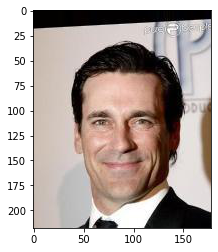

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

t = transforms.ToTensor()

if DATASET == 'dsprites':
    plt.imshow(dataset[6][0])
else:
    plt.imshow(dataset[6]['image'])

In [5]:
print(dataset[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x7F589EF9A1C0>}


In [6]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
device = torch.device("cuda:1")
class VAE(torch.nn.Module):
    def __init__(self, input_channel, input_height, input_width):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by ReLU activation function
        # 784 ==> 9

        self.input_height = input_height
        self.input_width  = input_width

        self.encoder = torch.nn.Sequential(
            nn.Conv2d(input_channel, 4, kernel_size= 3, stride= 1, padding  = 1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(),
            nn.Conv2d(4, 8, kernel_size= 3, stride= 2, padding  = 1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size= 3, stride= 2, padding  = 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size= 3, stride= 2, padding  = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
        )

        if input_channel == 3:
            self.output_height = 8
            self.output_width = 8
        else:
            self.output_height = 4
            self.output_width = 4

        self.mu = torch.nn.Linear(32*self.output_height*self.output_width, 30)
        self.sigma = torch.nn.Linear(32*self.output_height*self.output_width, 30)

        self.z_back = torch.nn.Linear(30, 32*self.output_height*self.output_width)

        self.mu_z = torch.zeros(1, 32)
        self.sigma_z = torch.ones(1, 32)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)

        self.log_scale = torch.nn.Parameter(torch.Tensor([0.0]))
         
        # Building an linear decoder with Linear
        # layer followed by ReLU activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size= 4, stride= 1, padding  = 1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size= 4, stride= 2, padding  = 1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size= 4, stride= 2, padding  = 1, output_padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.ConvTranspose2d(4, input_channel, kernel_size= 4, stride= 2, padding  = 1, output_padding=1),
            nn.BatchNorm2d(input_channel),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, sigma):
        z = mu + sigma * self.N.sample(mu.shape)
        return z
 
    def forward(self, x):
        # Parameters of Q(z|x)
        encoded = self.encoder(x)
        encoded = torch.flatten(encoded, start_dim=1)

        mu = self.mu(encoded)
        sigma = torch.exp(self.sigma(encoded)) # or use softplus , also have a lowerbound for sigma
        #print(sigma.max(), sigma.min())
        # Reparameterize trick
        z = self.reparameterize(mu, sigma)
        res = self.z_back(z)
        res = res.reshape(-1, 32, self.output_height, self.output_width)
        
        # Parameters of P(x|z)
        decoded = self.decoder(res)
        return decoded[:, :, :self.input_height, :self.input_width], z, mu, sigma

    def loss(self, xb_dash, xb, z, mu, sigma, loss_fn, kl_fn):

        #scale = torch.exp(self.log_scale)
        #p_xz = torch.distributions.Normal(xb_dash, scale)
        #recons_loss = p_xz.log_prob(xb)
        #recons_loss = recons_loss.mean(dim=1)  # It should be sum
        #recons_loss = recons_loss.mean(dim=0)

        # Assuming P(x|z) is a Gaussian, we can use MSE directly on xb' and xb
        # But still xb' are parameters of the prob dist P(x|z)
        # And it is not the reconstructed image itself
        recons_loss = loss_fn(xb_dash, xb)
        
        q = torch.distributions.Normal(mu, sigma)
        
        kld_loss = torch.mean(torch.distributions.kl.kl_divergence(q, self.N))
        #kld_loss = torch.mean(torch.sum( q.log_prob(z) - self.N.log_prob(z), dim=1), dim = 0)
        #print(kld_loss, kl)
        #kld_loss = torch.mean(-0.5 * torch.sum(1 + sigma - mu ** 2 - sigma.exp(), dim = 1), dim = 0)
        loss = recons_loss + (kld_loss * (30 / (3*64*64))) # 469 = Number of batches
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

In [7]:
# Model Initialization
model = VAE(input_channel, input_height, input_width)

#device = torch.device("cuda:0")
model.to(device)
 
# Validation using MSE Loss function
loss_fn = torch.nn.MSELoss()
cross_entropy_fn = torch.nn.CrossEntropyLoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3)

In [51]:
max_epochs = 10

loss_list = []
xb_fixed = next(iter(loader))[0].unsqueeze(0)
for e in range(1, max_epochs+1):
    epoch_loss = 0
    epoch_kl_loss = 0

    for xb in tqdm(loader):
        xb = xb.to(device)
        
        xb_dash, z, mu, sigma = model(xb)

        loss = model.loss(xb_dash, xb, z, mu, sigma, loss_fn, cross_entropy_fn)
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
        epoch_loss += float(loss['Reconstruction_Loss']) 
        epoch_kl_loss += float(loss['KLD'])
        loss_list.append(loss['loss'])
        #itera.set_postfix({"Recons": loss['Reconstruction_Loss'].item(), "KLD":loss['KLD'].item()} )
    calculate_marginal_likelihood(model, xb_fixed)
    print("Epoch loss: ", e, epoch_loss, epoch_kl_loss)
    torch.save(model.state_dict(), "vae_celeba.pth")

    # 31
    # 16 - 4th epoch

100%|██████████| 792/792 [01:16<00:00, 10.33it/s]
/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([128, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([128, 30]) torch.Size([128, 3, 64, 64])
Marginal likelihood:  tensor(0.1654, device='cuda:1', grad_fn=<ExpBackward0>)
Epoch loss:  1 20.82066425308585 1303.7511694431305


100%|██████████| 792/792 [01:16<00:00, 10.40it/s]


torch.Size([128, 30]) torch.Size([128, 3, 64, 64])
Marginal likelihood:  tensor(0.1657, device='cuda:1', grad_fn=<ExpBackward0>)
Epoch loss:  2 16.264482663944364 1267.9068740606308


100%|██████████| 792/792 [01:16<00:00, 10.34it/s]


torch.Size([128, 30]) torch.Size([128, 3, 64, 64])
Marginal likelihood:  tensor(0.1697, device='cuda:1', grad_fn=<ExpBackward0>)
Epoch loss:  3 14.07992409169674 1246.2811309099197


100%|██████████| 792/792 [01:15<00:00, 10.48it/s]


torch.Size([128, 30]) torch.Size([128, 3, 64, 64])
Marginal likelihood:  tensor(0.1672, device='cuda:1', grad_fn=<ExpBackward0>)
Epoch loss:  4 13.253526266664267 1241.302106976509


100%|██████████| 792/792 [01:15<00:00, 10.44it/s]


torch.Size([128, 30]) torch.Size([128, 3, 64, 64])
Marginal likelihood:  tensor(0.1664, device='cuda:1', grad_fn=<ExpBackward0>)
Epoch loss:  5 12.922025778330863 1231.059478878975


 58%|█████▊    | 462/792 [00:44<00:31, 10.36it/s]


KeyboardInterrupt: 

In [13]:
#import sklearn.mixture as sk
# Marginal Likelihood https://bjlkeng.github.io/posts/importance-sampling-and-estimating-marginal-likelihood-in-variational-autoencoders/
#GMM = sk.GaussianMixture(n_components=2)
def calculate_marginal_likelihood(model, xb):
    loss_fn_p = nn.MSELoss(reduction='none')
    model.eval()
    xb = xb.to(device)
    xb_dash, z, mu, sigma = model(xb)

    for i in range(127):
        xb_dash_sam, z_sample, mul, sigmal = model(xb)
        z = torch.cat((z, z_sample), dim=0)
        xb_dash = torch.cat((xb_dash, xb_dash_sam), dim=0)
    print(z.shape, xb_dash.shape)
    
    q = torch.distributions.Normal(mu, sigma)
    p_z = torch.logsumexp(model.N.log_prob(z), dim=1)
    #q_z = torch.Tensor(GMM.score_samples(z.detach().cpu().numpy())).to(device)
    q_z = torch.logsumexp(q.log_prob(z), dim=1)
    p_x_z = torch.mean(torch.flatten(loss_fn_p(xb_dash, xb), start_dim=1), dim=1)
    print("Marginal likelihood: ", torch.exp(torch.mean(-q_z + p_z + p_x_z)))


In [8]:
model = VAE(input_channel, input_height, input_width)

model.load_state_dict(torch.load("vae_celeba.pth"))
#device = torch.device("cuda:0")
model.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (mu): Linear(in_features=2048, out_features=30, bias=True)
  (sigma): Linear(in_features=2048, out_features=30, bias=True)
  (z_back): Linear(in_features

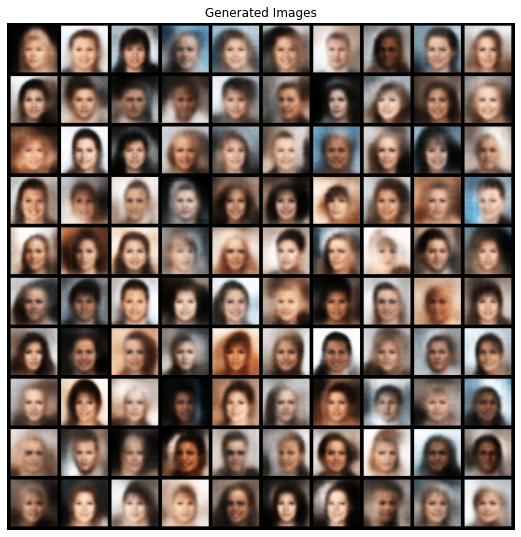

In [78]:
z = torch.randn(100, 128).to(device)
res = model.z_back(z)
res = res.reshape(-1, 32, model.output_height, model.output_width)
reel_batch = model.decoder(res)
reel_batch = reel_batch[:, :, :model.input_height, :model.input_width]
reel_batch = reel_batch * 255
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(reel_batch[:100], padding=5, nrow=10,normalize=True).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


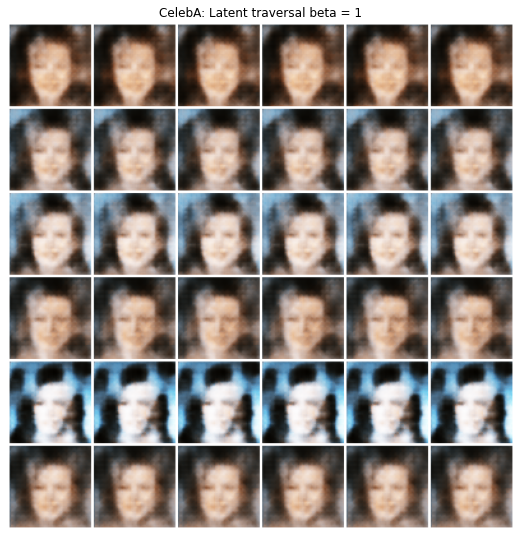

In [9]:
import torchvision.utils as vutils
xb = next(iter(loader)).to(device)[:36]
xb_dash, z, mu, sigma = model(xb)
#z = torch.randn(36, 512).to(device)
from random import randint

for i in range(36):
    if i % 6 == 0:
        y = torch.randint(low=0, high=512, size=(64,))
        continue
    else:
        z[i] = z[i- (i%6)]
        z[i][y] = z[i][y] + 0.2*(i%6)
res = model.z_back(z)
res = res.reshape(-1, 32, model.output_height, model.output_width)
reel_batch = model.decoder(res)
reel_batch = reel_batch[:, :, :model.input_height, :model.input_width]
reel_batch = reel_batch 
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("CelebA: Latent traversal beta = 1")
plt.imshow(np.transpose(vutils.make_grid(reel_batch[:36], padding=2, nrow=6, pad_value=254, normalize=True).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


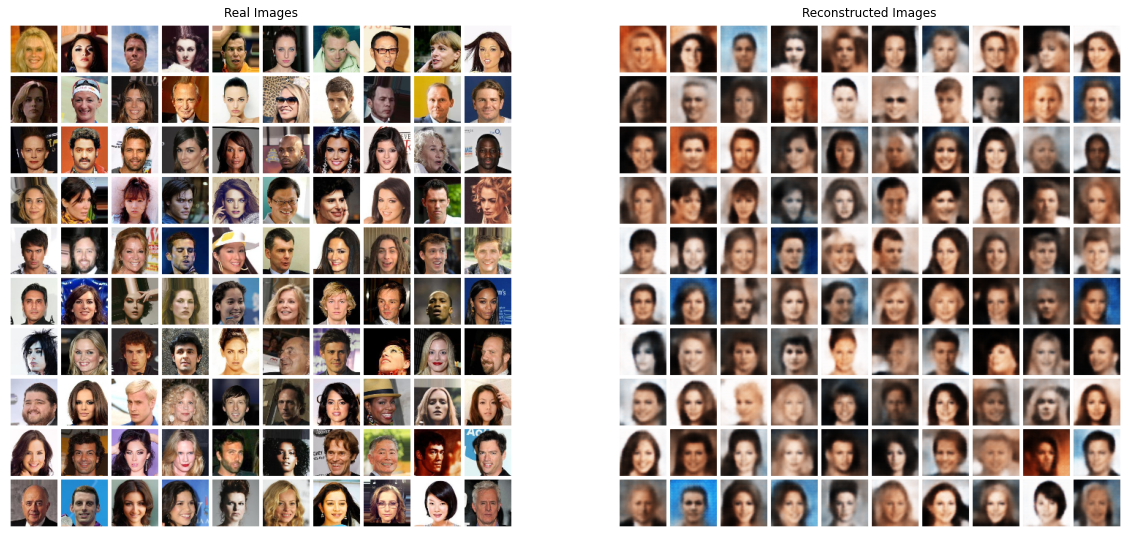

In [48]:
for xb in loader:
    xb = xb.to(device)
    reel_batch, z, mu, sigma = model(xb)
    break
#res = model.z_back(z)
#res = res.reshape(-1, 32, model.output_height, model.output_width)
#reel_batch = model.decoder(res)
#reel_batch = reel_batch[:, :, :model.input_height, :model.input_width]
#reel_batch = reel_batch * 255
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(xb[:100], padding=5, nrow=10, pad_value=255, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstructed Images")
plt.imshow(np.transpose(vutils.make_grid(reel_batch[:100], padding=5, nrow=10, pad_value=255, normalize=True).cpu(),(1,2,0)))

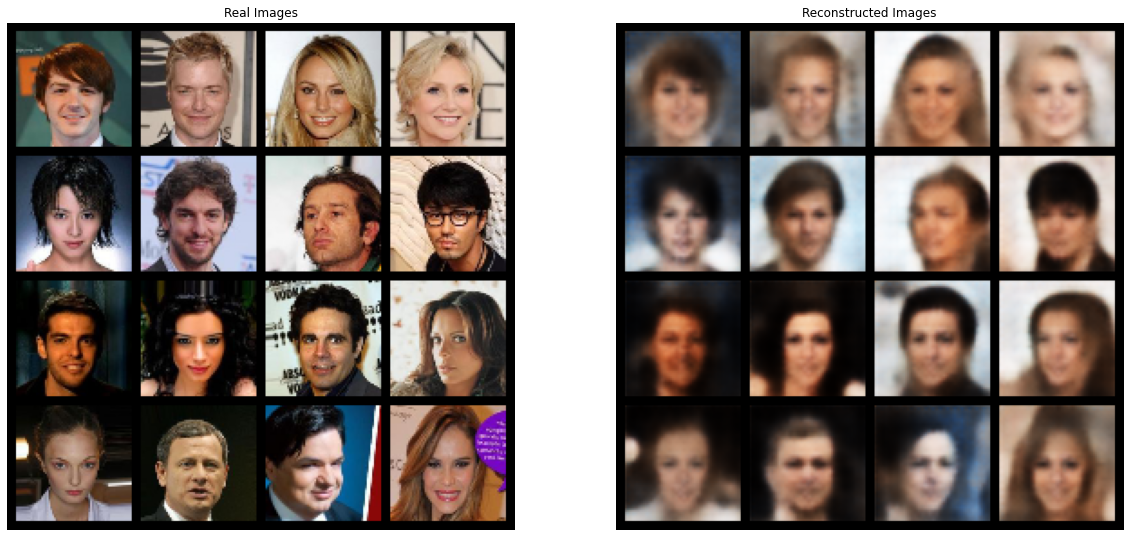

In [25]:
real_batch = next(iter(loader))
real_batch = real_batch.to(device)
reel_batch, z, mu, sigma = model(real_batch)

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:16], padding=5, nrow=4,normalize=True).cpu(),(1,2,0)))

# Plot the real images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstructed Images")
plt.imshow(np.transpose(vutils.make_grid(reel_batch[:16], padding=5, nrow=4, normalize=True).cpu(),(1,2,0)))

In [ ]:
# https://adamcobb.github.io/journal/hamiltorch.html



Observation:

1) If kernel size not divisible by stride in decoder - checkerboard effect - solution: upsampling (not learnable) or kernel size divisible by stride in convtranspose.

2) If kld weight more, posterior collapse.

3) If recons weight more, bad samples - samples are distributed.
